# 📂 Pneumonia Detection using Deep Learning

## 📋 Project Overview
This project focuses on detecting pneumonia from chest X-ray images using a **DenseNet121** convolutional neural network. The project includes dataset download, data preprocessing, model building, training visualization, evaluation, and deployment using **Gradio** for real-time predictions.


## ✅ Cell 1 — Import Required Libraries
- Import essential libraries for:
  - Data processing: `os`, `numpy`, `matplotlib`
  - Deep learning: `tensorflow.keras` with `DenseNet121`
  - Dataset download: `kagglehub`
  - Visualization: `matplotlib.pyplot`
  - Deployment interface: `gradio`

In [1]:
import os, shutil, zipfile
import numpy as np
import tensorflow as tf
import kagglehub
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import gradio as gr

##  Dataset Download and Extraction
- Download the **Chest X-Ray Pneumonia** dataset using `kagglehub`.
- Automatically extract and organize dataset into required folder structure:
  - `/train`
  - `/val`
  - `/test`
- Validates that all necessary directories are present before proceeding.


In [2]:
# Download and extract dataset
raw = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
DATA_ROOT = "/content/data"
TARGET = os.path.join(DATA_ROOT, "chest_xray")
shutil.rmtree(TARGET, ignore_errors=True)
os.makedirs(DATA_ROOT, exist_ok=True)

if os.path.isdir(raw):
    candidate = os.path.join(raw, "chest_xray")
    shutil.copytree(candidate if os.path.isdir(candidate) else raw, TARGET)
elif raw.endswith(".zip"):
    with zipfile.ZipFile(raw, "r") as z: z.extractall(DATA_ROOT)
    extracted = os.path.join(DATA_ROOT, "chest-xray-pneumonia", "chest_xray")
    os.rename(extracted, TARGET)

for split in ("train", "val", "test"):
    path = os.path.join(TARGET, split)
    assert os.path.isdir(path), f"Missing folder: {path}"


## ✅ Cell 3 — Dataset Preparation & Augmentation
- Defines:
  - Dataset directories and file paths.
  - Image dimensions as **(224, 224)**.
  - Batch size of **32**.
  - Number of epochs: **20**.
- **Training Generator**: Includes data augmentation for improved generalization.
- **Validation & Test Generators**: Use only rescaling for accurate evaluation.


In [3]:
# Cell 3
BASE_DIR = TARGET
TRAIN_DIR = BASE_DIR + "/train"
VAL_DIR = BASE_DIR + "/val"
TEST_DIR = BASE_DIR + "/test"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
MODEL_PATH = "/content/pneumonia_detector.h5"

train_gen = ImageDataGenerator(
    rescale=1./255, rotation_range=20, zoom_range=0.2,
    width_shift_range=0.2, height_shift_range=0.2,
    horizontal_flip=True
).flow_from_directory(TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary")

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    VAL_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary")

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary", shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## ✅ Cell 4 — Model Architecture & Training
- Loads **DenseNet121** pretrained on **ImageNet** (excluding top classification layer).
- Adds:
  - `GlobalAveragePooling2D` for dimensionality reduction.
  - `BatchNormalization` for stabilized training.
  - `Dropout` layers to reduce overfitting.
  - Dense layers for improved learning capacity.
- **Compilation:**
  - Optimizer: `Adam` (learning rate = 1e-4)
  - Loss function: `binary_crossentropy`
  - Metric: `accuracy`
- Adds callbacks:
  - **ModelCheckpoint**: Save best model weights.
  - **EarlyStopping**: Stop training early if validation loss doesn’t improve.
  - **ReduceLROnPlateau**: Reduce learning rate if validation loss stagnates.
- Trains the model on the prepared dataset.


In [5]:
# Cell 4
backbone = DenseNet121(weights="imagenet", include_top=False, input_shape=(*IMG_SIZE, 3))
for layer in backbone.layers: layer.trainable = False

x = GlobalAveragePooling2D()(backbone.output)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
out = Dense(1, activation="sigmoid")(x)
model = Model(inputs=backbone.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="binary_crossentropy", metrics=["accuracy"])

cp = ModelCheckpoint(MODEL_PATH, monitor="val_accuracy", save_best_only=True, verbose=1)
es = EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True, verbose=1)
lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[cp, es, lr]
)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.6902 - loss: 0.6474
Epoch 1: val_accuracy improved from -inf to 0.75000, saving model to /content/pneumonia_detector.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 154s 741ms/step - accuracy: 0.6906 - loss: 0.6468 - val_accuracy: 0.7500 - val_loss: 0.5058 - learning_rate: 1.0000e-04
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.8429 - loss: 0.3867
Epoch 2: val_accuracy improved from 0.75000 to 0.81250, saving model to /content/pneumonia_detector.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 633ms/step - accuracy: 0.8429 - loss: 0.3866 - val_accuracy: 0.8125 - val_loss: 0.4139 - learning_rate: 1.0000e-04
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.8770 - loss: 0.3195
Epoch 3: val_accuracy did not improve from 0.81250
163/163 ━━━━━━━━━━━━━━━━━━━━ 102s 626ms/step - accuracy: 0.8770 - loss: 0.3195 - val_accuracy: 0.8125 - val_loss: 0.3683 - learning_rate: 1.0000e-04
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.8951 - loss: 0.2969
Epoch 4: val_accuracy did not improve from 0.81250
163/163 ━━━━━━━━━━━━━━━━━━━━ 141s 619ms/step - accuracy: 0.8951 - loss: 0.2969 - val_accuracy: 0.8125 - val_loss: 0.3761 - learning_rate: 1.0000e-04
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.9095 - loss: 0.2477
Epoch 5: val_accuracy did not improve from 0.81250
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 617ms/step - accuracy: 0.9095 - loss: 0.2478 - val_accuracy: 0.8125 - val_loss: 0.3481 - learning_rate

163/163 ━━━━━━━━━━━━━━━━━━━━ 105s 642ms/step - accuracy: 0.9194 - loss: 0.2155 - val_accuracy: 0.8750 - val_loss: 0.3119 - learning_rate: 1.0000e-04
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.9249 - loss: 0.2050
Epoch 8: val_accuracy did not improve from 0.87500
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 617ms/step - accuracy: 0.9249 - loss: 0.2051 - val_accuracy: 0.8125 - val_loss: 0.3164 - learning_rate: 1.0000e-04
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.9220 - loss: 0.2060
Epoch 9: val_accuracy did not improve from 0.87500

Epoch 9: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 620ms/step - accuracy: 0.9220 - loss: 0.2060 - val_accuracy: 0.8125 - val_loss: 0.3174 - learning_rate: 1.0000e-04
Epoch 10/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.9292 - loss: 0.2029
Epoch 10: val_accuracy did not improve from 0.87500
163/163 ━━━━━━━━━━━━━━━━━━━━ 103s 632ms/step - accuracy: 

## ✅ Cell 5 — Training Visualization & Evaluation
- Plots **Training vs Validation Accuracy** graph to visualize model performance over epochs.
- Evaluates model on the **test dataset** to compute **final test accuracy**.


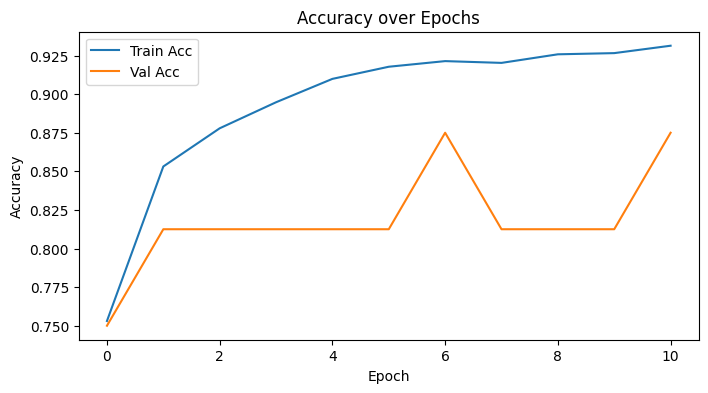

20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 225ms/step - accuracy: 0.8987 - loss: 0.2482
Test Accuracy: 91.51%


In [6]:
# Cell 5
plt.figure(figsize=(8,4))
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend(); plt.show()

loss, acc = model.evaluate(test_gen)
print(f"Test Accuracy: {acc * 100:.2f}%")


## ✅ Cell 6 — Prediction Function (Local Files)
- Defines the `predict_image()` function for:
  - Loading local image files.
  - Making predictions.
  - Returning:
    - Predicted label (`PNEUMONIA` or `NORMAL`).
    - Prediction confidence score.


In [7]:
# Cell 6
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    arr = image.img_to_array(img) / 255.0
    pred = model.predict(np.expand_dims(arr,0))[0][0]
    label = "PNEUMONIA" if pred > 0.5 else "NORMAL"
    conf  = pred if pred > 0.5 else 1 - pred
    return label, float(conf)



## ✅ Cell 7 — Gradio Interface (Web App)
- Defines the **Gradio** interface:
  - Accepts image uploads.
  - Returns prediction probabilities for **PNEUMONIA** or **NORMAL**.
- Launches a **public URL** using `share=True` for easy access and demonstration.

## 🚀 Final Outcome
✅ Real-time, web-based **Pneumonia Detection System**  
✅ Public shareable link for easy deployment and demonstration

In [8]:
# Cell 7
def gradio_predict(img):
    img = img.convert("RGB").resize(IMG_SIZE)
    arr = np.array(img)/255.0
    p = model.predict(np.expand_dims(arr,0))[0][0]
    return {"PNEUMONIA": float(p), "NORMAL": float(1-p)}

demo = gr.Interface(
    fn=gradio_predict,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=2),
    title="Pneumonia Detection",
    description="Upload a chest X-ray to detect pneumonia."
)

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://58dc080cdf0efd0221.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
